In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Hamiltonian Monte Carlo (HMC)

HMC is a Markov Chain Monte Carlo (MCMC) method that uses a symplectic integrator to explore a probability distribution. It is particularly useful for high-dimensional distributions and is often used in Bayesian statistics. Effectively, HMC treats the state vector $\boldsymbol{X}$ as a particle moving in the sample space, with the negative log target distribution as the potential energy landscape. In order to simulate a dynamical process, one duplicates the state vector space to introduce a conjugate momentum vector $\boldsymbol{P}$. The Hamiltonian of the system is then given by the sum of the potential energy (the negative logarithm of the target distribution) and the kinetic energy (the squared momentum), i.e.
$$
  H(\boldsymbol{X},\boldsymbol{P}) = -\log p(\boldsymbol{X}) + \tfrac{1}{2} \boldsymbol{P}^\top \boldsymbol{P}.
$$
The key insight of HMC is that the joint distribution $p(\boldsymbol{X}, \boldsymbol{P}) \propto \exp(-H(\boldsymbol{X}, \boldsymbol{P}))$ has marginal distributions corresponding to our target distribution $p(\boldsymbol{X})$ and a standard normal distribution for $\boldsymbol{P}$. In the ergodic limit, simulating Hamiltonian dynamics preserves this joint distribution due to both energy conservation and volume preservation (Liouville's theorem).

The dynamics of the system are then simulated using Hamilton's equations of motion, which describe how the position and momentum of the particle evolve over time. As you remember from classical mechanics or our unit on symplectic integrators, Hamilton's equations are given by
$$
\begin{align*}
  \frac{{\rm d}\boldsymbol{X}}{{\rm d}t} &= \nabla_P H = \boldsymbol{P}, \\
  \frac{{\rm d}\boldsymbol{P}}{{\rm d}t} &= -\nabla_X H = \nabla \log p(\boldsymbol{X}).
\end{align*}
$$
They can be solved using a symplectic integrator, e.g. a leapfrog. A leapfrog step consists of the following operations, given an initial state $(\boldsymbol{X}_0,\boldsymbol{P}_0)$ and a step size $\epsilon>0$:
$$
\begin{align*}
  \boldsymbol{P}_{i+1/2} &= \boldsymbol{P}_i - \frac{\epsilon}{2} \nabla \log p(\boldsymbol{X}_i), \\
  \boldsymbol{X}_{i+1} &= \boldsymbol{X}_i + \epsilon \boldsymbol{P}_{i+1/2}, \\
  \boldsymbol{P}_{i+1} &= \boldsymbol{P}_{i+1/2} - \frac{\epsilon}{2} \nabla \log p(\boldsymbol{X}_{i+1}).
\end{align*}
$$
In standard HMC, the momentum $\boldsymbol{P}$ is initialized from a standard normal distribution, then the leapfrog integrator is applied for $L$ steps, and finally the new state $(\boldsymbol{X}_{L},\boldsymbol{P}_{L})$ is accepted with probability
$$
  \alpha = \min\left(1, \exp\left(-H(\boldsymbol{X}_{L},\boldsymbol{P}_{L}) + H(\boldsymbol{X}_{0},\boldsymbol{P}_{0})\right)\right).
$$
This acceptance probability is high since the leapfrog conserves the Hamiltonian, and thus the energy of the system is preserved. 

In [2]:
# HMC sampler
def hmc_sampler(log_target_density, grad_log_target_density, num_samples, X0, step_size=0.1, num_leapfrog_steps=10):
    samples = []
    current_sample = X0.copy()  # Initialize with given state
    samples_accepted = 0
    
    for _ in range(num_samples):
        # Current state and momentum
        position = current_sample.copy()
        momentum = np.random.normal(0, 1, size=2)
        
        # Compute the current Hamiltonian
        current_log_density = log_target_density(position)
        current_hamiltonian = -current_log_density + 0.5 * np.sum(momentum**2)
        
        # Simulate Hamiltonian dynamics using leapfrog integration
        new_position = position
        new_momentum = momentum
        
        # Half-step momentum update
        new_momentum += 0.5 * step_size * grad_log_target_density(new_position)
        
        # Full-step position and momentum updates
        for _ in range(num_leapfrog_steps):
            new_position += step_size * new_momentum
            if _ < num_leapfrog_steps - 1:  # Skip the last momentum update
                new_momentum += step_size * grad_log_target_density(new_position)
        
        # Final half-step momentum update
        new_momentum += 0.5 * step_size * grad_log_target_density(new_position)
        
        # Compute the new Hamiltonian
        new_log_density = log_target_density(new_position)
        new_hamiltonian = -new_log_density + 0.5 * np.sum(new_momentum**2)
        
        # Metropolis acceptance step
        if np.random.rand() < np.exp(current_hamiltonian - new_hamiltonian):
            current_sample = new_position
            samples_accepted += 1

        samples.append(current_sample)

    print(f"Acceptance rate (accepted/samples): {samples_accepted / num_samples }")
    print(f"Efficiency rate (accepted/p evaluated): {samples_accepted / num_samples / num_leapfrog_steps}")
    
    return np.array(samples), samples_accepted / num_samples

## Example usage

In [3]:
# Parameters for the HMC sampler
N = 100000    # Number of samples
Nleapfrog = 10  # Number of leapfrog steps
sigma = 0.1 # Step size for leapfrog integration

# Parameters of the banana distribution
a = 1.0
b = 10.0

# Define the target bivariate Gaussian distribution (log-density and its gradient)
def log_target_density_banana(x, a, b):
    return -0.5 * (a*x[0]**2 + b*(x[1] - x[0]**2)**2)

def grad_log_target_density_banana(x, a, b):
    diff_x0 = -x[0]*(a+2*b*(x[0]**2-x[1]))
    diff_x1 = b*(x[0]**2-x[1])
    return np.array([diff_x0, diff_x1])

# Run the HMC sampler
X0 = np.array([-1.0, -1.0])  # Initial state
states, alpha = hmc_sampler( lambda x: log_target_density_banana(x,a,b), lambda x: grad_log_target_density_banana(x,a,b), N, X0, step_size=sigma, num_leapfrog_steps=Nleapfrog)


Acceptance rate (accepted/samples): 0.96302
Efficiency rate (accepted/p evaluated): 0.096302


## Effective sample size
The effective sample size (ESS) is a measure of the number of independent samples in a Markov chain. It is defined as
$$
  \text{ESS} = \frac{N}{1 + 2\sum_{k=1}^{M} \xi(k)},
$$
where $N$ is the total number of samples, $\xi(k)$ is the autocorrelation at lag $k$, and $M$ is a finite truncation point. The truncation point can be determined through the 'initial monotone sequence estimator' (extend lag while autocorr positive and monotonically decreasing). The ESS can be interpreted as the number of independent samples that would provide the same amount of information as the correlated samples from the Markov chain. A higher ESS indicates that the Markov chain is mixing well and producing more independent samples.

In [4]:
def compute_ess(samples):
  """
  Compute the effective sample size (ESS) of the samples using the initial monotone sequence estimator.
  """
  n = len(samples)
  if n <= 1:
    return 0
  
  # Center the samples and calculate autocorrelation
  centered = samples - np.mean(samples)
  acov = np.correlate(centered, centered, mode='full')[n-1:] / n
  acf = acov / acov[0]
  
  # Initial monotone sequence estimator
  max_lag = min(n // 2, 250)
  xi_hat = [acf[1]]
  
  # Find consecutive pairs that are positive and monotonically decreasing
  for lag in range(1, max_lag // 2):
    if 2*lag+1 >= len(acf):
      break
      
    curr_sum = acf[2*lag] + acf[2*lag+1]
    prev_sum = acf[2*lag-2] + acf[2*lag-1]
    
    if curr_sum <= 0 or curr_sum > prev_sum:
      break
      
    xi_hat.append(curr_sum)
  
  # Calculate and return ESS
  return n / (1 + 2 * sum(xi_hat))


In [5]:
ness = compute_ess(states[:,0])
print(f"ESS: {ness}")
ndown = N // int(ness)
print('Should use only every', ndown, 'th sample')

ESS: 4610.321119483134
Should use only every 21 th sample


## Plot resulting samples and downsampled version to ESS size

Text(0.5, 1.0, 'Effective Sample (N=4610.321119483134)')

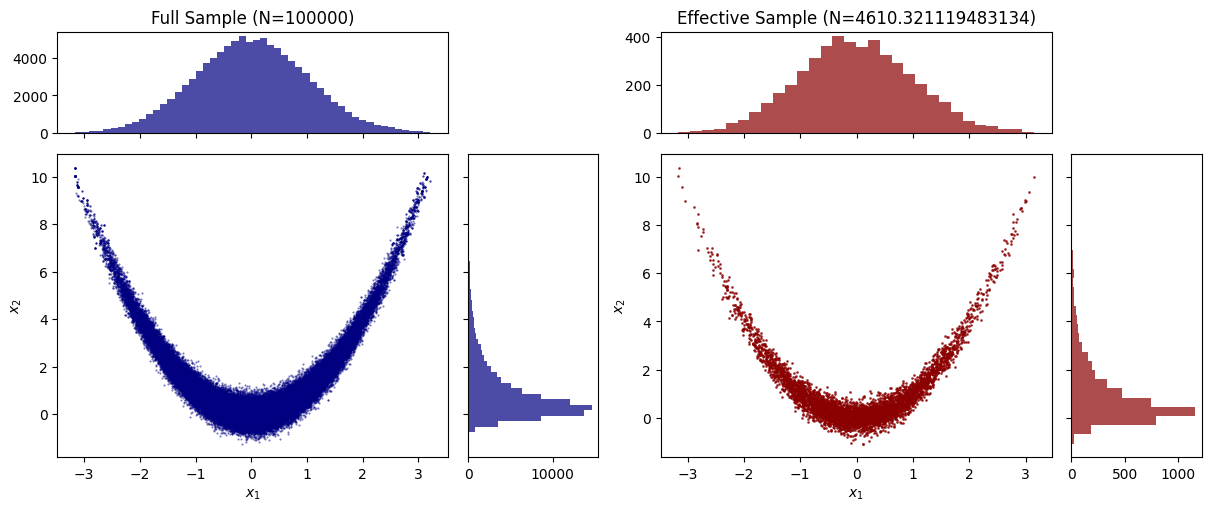

In [6]:
from matplotlib.gridspec import GridSpec

# Create a figure with a 2x3 grid layout for each plot plus margins
fig = plt.figure(figsize=(12, 5), layout='constrained')
gs = GridSpec(2, 4, width_ratios=[3, 1, 3, 1], height_ratios=[1, 3], 
        wspace=0.05, hspace=0.05, figure=fig)

# Main scatter plots
ax_scatter1 = fig.add_subplot(gs[1, 0])
ax_scatter2 = fig.add_subplot(gs[1, 2])

# Marginal histograms
ax_histx1 = fig.add_subplot(gs[0, 0], sharex=ax_scatter1)
ax_histy1 = fig.add_subplot(gs[1, 1], sharey=ax_scatter1)
ax_histx2 = fig.add_subplot(gs[0, 2], sharex=ax_scatter2)
ax_histy2 = fig.add_subplot(gs[1, 3], sharey=ax_scatter2)

# Turn off axis labels for the marginals
plt.setp(ax_histx1.get_xticklabels(), visible=False)
plt.setp(ax_histx2.get_xticklabels(), visible=False)
plt.setp(ax_histy1.get_yticklabels(), visible=False)
plt.setp(ax_histy2.get_yticklabels(), visible=False)

# Plot main scatter plots with smaller points
ax_scatter1.scatter(states[:,0], states[:,1], s=0.3, alpha=0.5, c='navy')
ax_scatter2.scatter(states[::ndown,0], states[::ndown,1], s=1, alpha=0.7, c='darkred')

# Plot marginal histograms
ax_histx1.hist(states[:,0], bins=50, color='navy', alpha=0.7)
ax_histy1.hist(states[:,1], bins=50, orientation='horizontal', color='navy', alpha=0.7)
ax_histx2.hist(states[::ndown,0], bins=30, color='darkred', alpha=0.7)
ax_histy2.hist(states[::ndown,1], bins=30, orientation='horizontal', color='darkred', alpha=0.7)

# Labels
ax_scatter1.set_xlabel('$x_1$')
ax_scatter1.set_ylabel('$x_2$')
ax_scatter2.set_xlabel('$x_1$')
ax_scatter2.set_ylabel('$x_2$')

# Titles
ax_histx1.set_title('Full Sample (N={})'.format(N))
ax_histx2.set_title('Effective Sample (N={})'.format(ness))


